# Tackling open problems with `QAOAKit`

`QAOAKit` is a unique tool for the study of QAOA. Here, we show how it can be used to tackle two open problems in quantum optimization.

### Problem 1: when does QAOA do poorly?

An important question is identifying the properties of instances that lead to QAOA doing poorly or well on these instances. Let's see how QAOAKit data can help us tackle this question.

Let's begin by load all the data we have

In [1]:
from QAOAKit import get_full_qaoa_dataset_table, get_3_reg_dataset_table

df = get_full_qaoa_dataset_table().reset_index()
df = df.append(get_3_reg_dataset_table().reset_index())
print(f"Dataset contains {len(df)} instances")

Dataset contains 866383 instances


Ref [1] suggests that symmetry of the problem may be a powerful predictor of QAOA performance. Let's see if this is indeed the case. 

We will use the number of vertex orbits as the chosen measure of graph symmetry. An orbit is a class of equivalence imposed on vertices by the symmetry (automorphism). The fewer orbits the graph has, the more symmetric it is. For example, a cycle graph has only one vertex orbit as any vertex can be "rotated" into any other one. We will use `pynauty` to compute the group of automorphisms.

Number of vertex orbits: 1


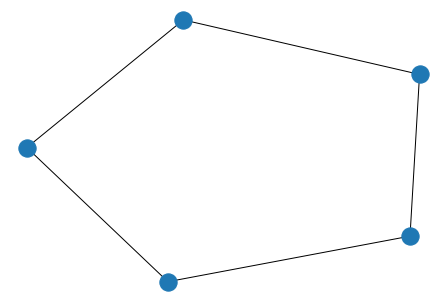

In [2]:
import networkx as nx
import pynauty
from QAOAKit.utils import get_adjacency_dict

def get_number_of_orbits(G):
    """Returns the number of vertex orbits of a graph
    """
    assert isinstance(G, nx.Graph)
    g = pynauty.Graph(number_of_vertices=G.number_of_nodes(), directed=nx.is_directed(G),
                        adjacency_dict = get_adjacency_dict(G))
    return pynauty.autgrp(g)[4]

G = nx.cycle_graph(5)
print(f"Number of vertex orbits: {get_number_of_orbits(G)}")
nx.draw(G)

Now, let's compute this value for every instance in the dataset

In [3]:
from tqdm import tqdm                    
tqdm.pandas()          

df['Number of orbits'] = df.progress_apply(
    lambda row: get_number_of_orbits(row['G']),
    axis = 1,
)

100%|██████████| 866383/866383 [00:28<00:00, 30675.36it/s]


And compute mean approximation ratio for each value of QAOA depth `p` and number of nodes `n`.

In [4]:
df['Approximation ratio'] = df['C_opt'] / df['C_{true opt}']

In [5]:
ratio_by_p_and_n = (
    df.groupby(['p_max','Number of orbits','n'])
    .mean()['Approximation ratio']
    .dropna()
    .reset_index()
)

First, let's look at graph with 9 nodes. For these, our dataset includes all non-isomorphic 9 node graphs

Looking at 783240 9-node graphs


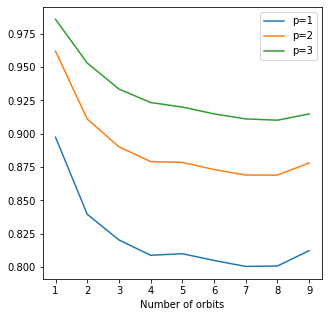

In [6]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(5,5), sharey=True)

print(f"Looking at {len(df[df['n'] == 9])} 9-node graphs")

for p in [1,2,3]:
    ratio_by_p_and_n[
        (ratio_by_p_and_n['p_max'] == p) & (ratio_by_p_and_n['n'] == 9)
    ].plot(y='Approximation ratio', x='Number of orbits', label=f'p={p}', ax=ax)

It looks like the most symmetric graphs are the easiest for QAOA! Now, let's consider all non-isomorphic 16-node 3-regular graphs.

Looking at 40600 16-node 3-regular graphs


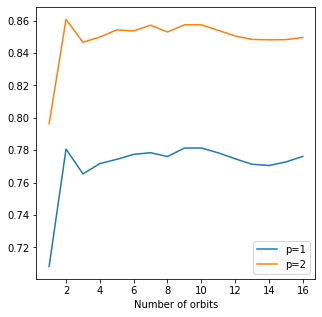

In [7]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(5,5), sharey=True)

print(f"Looking at {len(df[df['n'] == 16])} 16-node 3-regular graphs")

for p in [1,2]:
    ratio_by_p_and_n[
        (ratio_by_p_and_n['p_max'] == p) & (ratio_by_p_and_n['n'] == 16)
    ].plot(y='Approximation ratio', x='Number of orbits', label=f'p={p}', ax=ax)

Now the most symmetric instances appear to be the hardest. Why is this the case? Perhaps the dataset contains an answer!

## References

[1] Shaydulin, R., Hadfield, S., Hogg, T., & Safro, I. (2020). Classical symmetries and QAOA. arXiv:2012.04713.